In [36]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fates_calibration.FATES_calibration_constants import FATES_PFT_IDS, FATES_INDEX

In [37]:
def plot_parameter_hists(sample, min_max_pars):
    
    pars = [par for par in sample.columns if par != 'wave']
    
    plt.figure(figsize=[18, 16])
    for i, par in enumerate(pars):
        
        par_min_max = pars_pft[pars_pft.parameter == par]
        
        minpar = [float(s) for s in par_min_max[par_min_max.type == 'min']['val'].values[0].split('_')]
        maxpar = [float(s) for s in par_min_max[par_min_max.type == 'max']['val'].values[0].split('_')]
        defaultpar = [float(s) for s in par_min_max['default'].values[0].split('_')]
        top = [default - minp for default, minp in zip(defaultpar, minpar)]
        bottom = [maxp - minp for maxp, minp in zip(maxpar, minpar)]
        p = [t/b for t, b in zip(top, bottom)]
        
        if len(p) > 1:
            p = np.mean(p)
        else:
            p = p[0]
        ax = plt.subplot(7, 5, i + 1)
        ax.hist(sample[par])
        ax.axvline(x=p, color='r', linestyle='-')
        ax.set_xlabel(par)
        ax.set_xlim(0, 1)
    plt.tight_layout()

def get_param_samples(sample_dir):
    
    files = sorted([os.path.join(sample_dir, file) for file in os.listdir(sample_dir) if file.endswith(".csv")])
    sample_dfs = []
    for file in files:
        df = pd.read_csv(file, index_col=[0])
        sample_dfs.append(df)
    sample_df = pd.concat(sample_dfs)
    sample_df = sample_df.drop(columns=['wave'])

    return sample_df

def get_default_pars(lhckey, in_pars):
    
    lhkey_df = pd.read_csv(lhckey)
    lhkey_df = lhkey_df.drop(columns=['ensemble'])
    param_names = lhkey_df.columns

    default_pars = [par for par in param_names if par not in in_pars]

    return default_pars

In [137]:
def rescale_par(par, parval, pars_pft):
    par_min_max = pars_pft[pars_pft.parameter == par]

    minpar = [float(s) for s in par_min_max[par_min_max.type == 'min']['val'].values[0].split('_')]
    maxpar = [float(s) for s in par_min_max[par_min_max.type == 'max']['val'].values[0].split('_')]
    
    first = [parval*(maxp - minp) for maxp, minp in zip(maxpar, minpar)]
    val = [f + minp for f, minp in zip(first, minpar)]
    
    return val[0]

In [160]:
def choose_pars(sample_df, var_choose):
    var_median = sample_df[var_choose].median()
    sample_df['var_diff'] = np.abs(sample_df[var_choose] - var_median)
    choose_index = np.argmin(sample_df.var_diff)
    sample_df = sample_df.drop(columns=['var_diff'])

    final_pars_scaled = sample_df.iloc[choose_index]
    pars = sample_df.columns

    final_pars = []
    for i, parval in enumerate(final_pars_scaled):
        final_pars.append(rescale_par(pars[i], parval, pars_pft))

    final_pars_df = pd.DataFrame({'parameter': pars, 'value': final_pars})
    return final_pars_df

In [230]:
pft = 'needleleaf_evergreen_extratrop_tree'
pft_id = FATES_PFT_IDS[pft]
round = 1

In [231]:
lhckey = '/glade/u/home/afoster/FATES_Calibration/lh_key.csv'
min_max_pars = pd.read_csv('/glade/u/home/afoster/FATES_Calibration/FATES_LH_min_max_crops.csv')
pars_pft = min_max_pars[min_max_pars.pft == str(FATES_INDEX[pft])]

sample_dir = f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/samples"

In [232]:
sample_df = get_param_samples(sample_dir)
#sample_df.to_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/sample_df_{round}.csv")

In [233]:
pars = sample_df.columns
default_pars = get_default_pars(lhckey, pars)
default_pars

['fates_nonhydro_smpsc', 'fates_nonhydro_smpso']

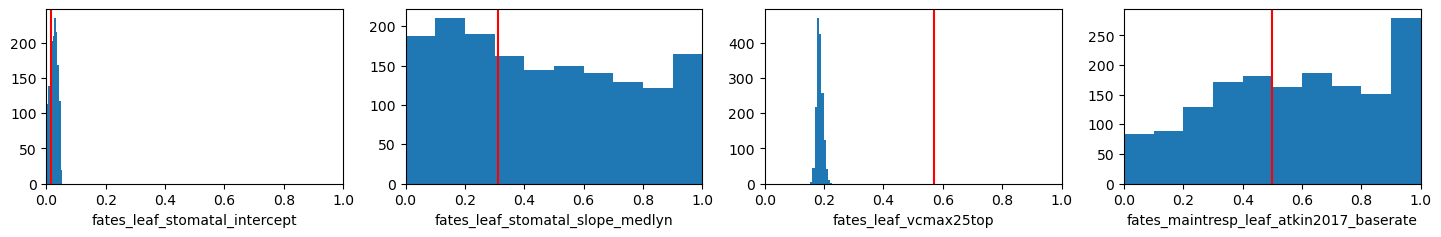

In [234]:
plot_parameter_hists(sample_df, pars_pft)
#plt.savefig(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/parameter_hists_{round}.png")

In [206]:
final_pars = choose_pars(sample_df, 'fates_leaf_vcmax25top')
final_pars['pft'] = pft
final_pars.to_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/final_pars.csv")

In [235]:
corr = sample_df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')
 .format(precision=2))

,fates_leaf_stomatal_intercept,fates_leaf_stomatal_slope_medlyn,fates_leaf_vcmax25top,fates_maintresp_leaf_atkin2017_baserate
fates_leaf_stomatal_intercept,nan,nan,nan,nan
fates_leaf_stomatal_slope_medlyn,-0.81,nan,nan,nan
fates_leaf_vcmax25top,0.26,-0.57,nan,nan
fates_maintresp_leaf_atkin2017_baserate,0.44,0.14,-0.38,nan


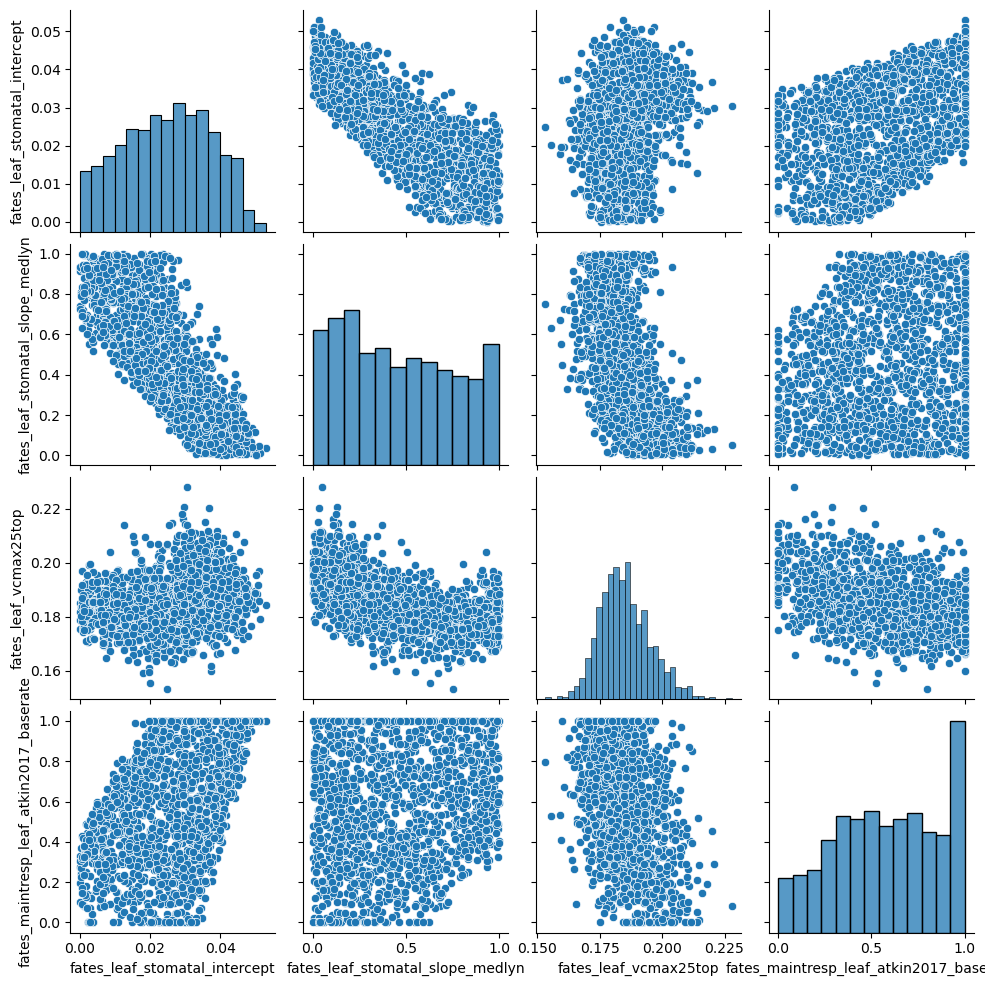

In [236]:
sns.pairplot(sample_df)
#plt.savefig(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/pairplot_{round}.png")

In [216]:
final_par_dfs = []
for pft in ['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree',
            'needleleaf_colddecid_extratrop_tree', 'arctic_c3_grass', 'cool_c3_grass',
            'c4_grass']:
    pft_id = FATES_PFT_IDS[pft]
    df = pd.read_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/final_pars.csv",
                                    index_col=[0])
    df['pft_index'] = FATES_INDEX[pft]
    final_par_dfs.append(df)
final_par_df = pd.concat(final_par_dfs)

In [218]:
np.unique(final_par_df.parameter)

array(['fates_leaf_stomatal_intercept',
       'fates_leaf_stomatal_slope_medlyn', 'fates_leaf_vcmax25top',
       'fates_maintresp_leaf_atkin2017_baserate', 'fates_nonhydro_smpsc',
       'fates_nonhydro_smpso'], dtype=object)

In [223]:
final_par_df[final_par_df.parameter == 'fates_nonhydro_smpso']

,parameter,value,pft,pft_index
4,fates_nonhydro_smpso,-53886.340614,broadleaf_evergreen_tropical_tree,1
4,fates_nonhydro_smpso,-34025.616338,needleleaf_colddecid_extratrop_tree,3
4,fates_nonhydro_smpso,-45126.289143,c4_grass,12


In [229]:
final_par_df

,parameter,value,pft,pft_index
0,fates_leaf_stomatal_intercept,14619.732514,broadleaf_evergreen_tropical_tree,1
1,fates_leaf_vcmax25top,52.743684,broadleaf_evergreen_tropical_tree,1
2,fates_leaf_stomatal_slope_medlyn,2.611827,broadleaf_evergreen_tropical_tree,1
3,fates_nonhydro_smpsc,-129435.704287,broadleaf_evergreen_tropical_tree,1
4,fates_nonhydro_smpso,-53886.340614,broadleaf_evergreen_tropical_tree,1
0,fates_leaf_stomatal_intercept,10509.090365,needleleaf_evergreen_extratrop_tree,2
1,fates_leaf_stomatal_slope_medlyn,3.081301,needleleaf_evergreen_extratrop_tree,2
2,fates_leaf_vcmax25top,28.386242,needleleaf_evergreen_extratrop_tree,2
3,fates_maintresp_leaf_atkin2017_baserate,1.465376,needleleaf_evergreen_extratrop_tree,2
0,fates_leaf_stomatal_intercept,4048.945147,needleleaf_colddecid_extratrop_tree,3
